In [1]:
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers.merging import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import EarlyStopping
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io
from PIL import Image, ImageFilter
import cv2
import os
import requests
import pandas as pd
from urllib.request import urlopen

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.layers.activation.prelu import PReLU
from keras.layers.reshaping.cropping2d import Cropping2D

In [3]:
from roughviz.charts import Line
from cutecharts.charts import Line
from keras.callbacks import LearningRateScheduler


In [4]:
path = "photos/train/"
testPath = "photos/test/"

In [5]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(path, target_size=(256,256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


In [6]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(testPath, target_size=(256, 256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


# **Convolutional Neural Network**

## Model Testing Ideas:

* Using different types of activation functions. 
    - PreLU
    - <mark>Leaky ReLU</mark>
    - ReLU
* Changing the validation
    - <mark>with</mark> or without validation set
    - validation steps
* Changing the complexity of the model. 
    - conv2D based network with incrementing filter sizes until 256 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 128 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 64 and decrementing back to 16
    - only increments
* Using different preprocessing techniques
    - adding blur to images before entering the network
    - trying differently sized images
    - maybe some kind of other smoothing or denoising effect
* Trying different learning rates
* Trying different optimizers
* Image Augmentation
* Different Datasets

In [481]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [482]:
X_,y_ = ExtractInput(ImagePath)

In [483]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [484]:
X_[0].shape

(256, 256)

In [485]:
X_test[0].shape

(256, 256)

In [486]:
from keras.layers.core.dense import Dense
from keras.layers import Dropout

In [40]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
#    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [41]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [60]:
initial_learning_rate = 0.01
epochs = 3
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * (1 / (1 + decay * epoch))

In [61]:
LEARNING_RATE = 0.01
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error', metrics=["acc"])
Model_Colourization.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_54 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_58[0][0]']              
                                )                                                           

In [82]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[es])
history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=40, callbacks=[es])#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])

Epoch 1/12


C:\Users\jrsco\AppData\Local\Temp\ipykernel_23196\2244812203.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=40, callbacks=[es])#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


5/5 [==============================] - 24s 5s/step - loss: 0.0323 - acc: 0.2530 - val_loss: 0.9456 - val_acc: 0.0334
Epoch 2/12
5/5 [==============================] - 23s 5s/step - loss: 0.0286 - acc: 0.0418 - val_loss: 0.6730 - val_acc: 0.0191
Epoch 3/12
5/5 [==============================] - 24s 5s/step - loss: 0.0289 - acc: 0.6727 - val_loss: 0.6565 - val_acc: 0.9408
Epoch 4/12
5/5 [==============================] - 24s 5s/step - loss: 0.0229 - acc: 0.9564 - val_loss: 0.7188 - val_acc: 0.9693
Epoch 5/12
5/5 [==============================] - 23s 5s/step - loss: 0.0203 - acc: 0.1128 - val_loss: 0.8898 - val_acc: 0.8993
Epoch 6/12
5/5 [==============================] - 23s 5s/step - loss: 0.0193 - acc: 0.2374 - val_loss: 0.6126 - val_acc: 0.9544
Epoch 7/12
5/5 [==============================] - 22s 5s/step - loss: 0.0186 - acc: 0.8240 - val_loss: 0.7454 - val_acc: 0.9500
Epoch 8/12
5/5 [==============================] - 22s 5s/step - loss: 0.0179 - acc: 0.6548 - val_loss: 0.4388 - val

In [83]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [84]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [72]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [88]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 349ms/step
Prediction made
reshaped


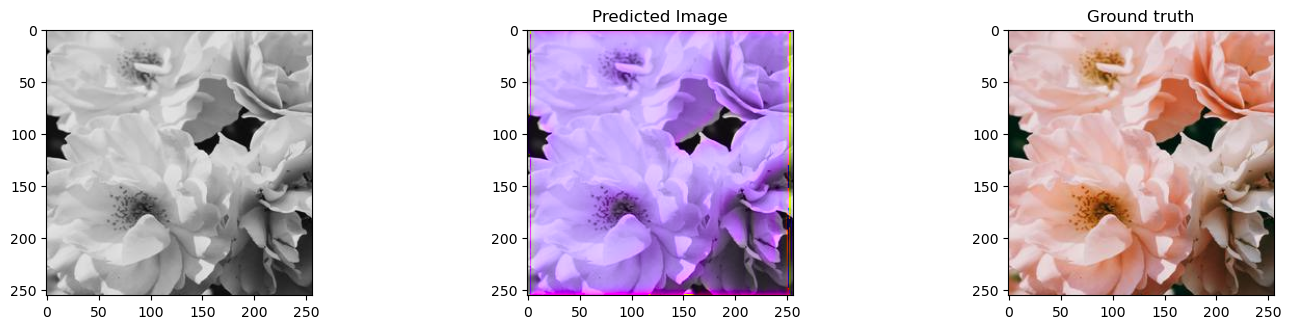

In [89]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2BGR)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

# **Autoencoder Method**

## Setup

In [7]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [9]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [10]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [112]:
def InstantiateAutoencoderModel(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
#    model_ = Dropout(rate=0.2)(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)


    print(model_)
    print(in_)

    concat_ = concatenate([model_, in_]) 

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(rate=0.2)(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(16,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
#    model_ = Dense(units=2)(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)
    model_ = UpSampling2D((2,2))(model_)    

    return model_

In [115]:
def initAutoEncoder(in_):
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)


    print(model_)
    print(in_)
    
#    model_ = Dropout(rate=0.2)(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(256, (3,3), padding="same", strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(128, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(64, (3,3), padding="same", strides=1)(model_)
    model_ = LeakyReLU()(model_)

    model_ = Conv2D(32, (3,3), padding="same", strides=1)(model_)

    model_ = Conv2D(16, (3,3), padding="same", strides=1)(model_)

    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)
   # model_ = UpSampling2D((2,2))(model_)    

    print(model_)
    print(in_)

    return model_

In [91]:
from keras.layers import Flatten
from keras.layers import Dense

In [92]:
# Input layer
input_img = Input(shape=(256, 256, 1))

# Encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Flatten and Dense layers for non-spatial feature extraction
#flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(pool2)
dense2 = Dense(64, activation='relu')(dense1)
print(dense2)
# Decoder
upsample1 = UpSampling2D((2, 2))(dense2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(upsample1)
upsample2 = UpSampling2D((2, 2))(conv3)
decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(upsample2)

# Define the model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print the model summary
autoencoder.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_70 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                

In [116]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = initAutoEncoder(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 256), dtype=tf.float32, name=None), name='up_sampling2d_24/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_24'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_16'), name='input_16', description="created by layer 'input_16'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None), name='conv2d_117/Tanh:0', description="created by layer 'conv2d_117'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_16'), name='input_16', description="created by layer 'input_16'")


In [556]:
from keras.losses import MeanAbsolutePercentageError

In [117]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss="mse", metrics=["acc"])
Model_Colourization.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_109 (Conv2D)            (None, 256, 256, 64  640         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_97 (LeakyReLU)     (None, 256, 256, 64  0           ['conv2d_109[0][0]']             
                                )                                                           

c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [575]:
initial_learning_rate = 0.001
epochs = 12
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [552]:
from keras.callbacks import LearningRateScheduler

In [118]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=5)

history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])

Epoch 1/12


C:\Users\jrsco\AppData\Local\Temp\ipykernel_23196\3835236990.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=20)#, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])#, callbacks=[es])


5/5 [==============================] - 57s 12s/step - loss: 0.5325 - acc: 0.4690 - val_loss: 0.9975 - val_acc: 0.0079
Epoch 2/12
5/5 [==============================] - 59s 13s/step - loss: 0.7694 - acc: 0.1518 - val_loss: 0.9999 - val_acc: 0.9986
Epoch 3/12
5/5 [==============================] - 55s 12s/step - loss: 0.6354 - acc: 0.6958 - val_loss: 1.0000 - val_acc: 0.9644
Epoch 4/12
5/5 [==============================] - 56s 13s/step - loss: 0.9555 - acc: 0.8236 - val_loss: 1.0000 - val_acc: 0.9998
Epoch 5/12
5/5 [==============================] - 59s 13s/step - loss: 0.7828 - acc: 0.9285 - val_loss: 0.9982 - val_acc: 0.0150
Epoch 6/12
5/5 [==============================] - 55s 12s/step - loss: 0.3209 - acc: 0.4775 - val_loss: 0.9999 - val_acc: 0.9806
Epoch 7/12
5/5 [==============================] - 59s 13s/step - loss: 0.1231 - acc: 0.9584 - val_loss: 1.0000 - val_acc: 0.9883
Epoch 8/12
5/5 [==============================] - 53s 12s/step - loss: 0.0889 - acc: 0.2661 - val_loss: 0.99

In [119]:
data = {
    "acc": list(history.history["acc"]),
    "val_acc": list(history.history["val_acc"]),
    "loss": list(history.history["loss"]),
    "val_loss": list(history.history["val_loss"])
}

In [120]:
chart = Line("Model Results")
chart.set_options(
    labels=[1,2,3,4,5,6,7,8,9,10,11,12],
    x_label="Epoch",
    y_label="Percent",
)


chart.add_series("acc", data["acc"])
chart.add_series("val_acc", data["val_acc"])
chart.add_series("loss", data["loss"])
chart.add_series("val_loss", data["val_loss"])
chart.render_notebook()

In [121]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [126]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"
#TestImagePath="photos/test/test_data/3bh3elC0D7M.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 2s 2s/step
Prediction made
reshaped


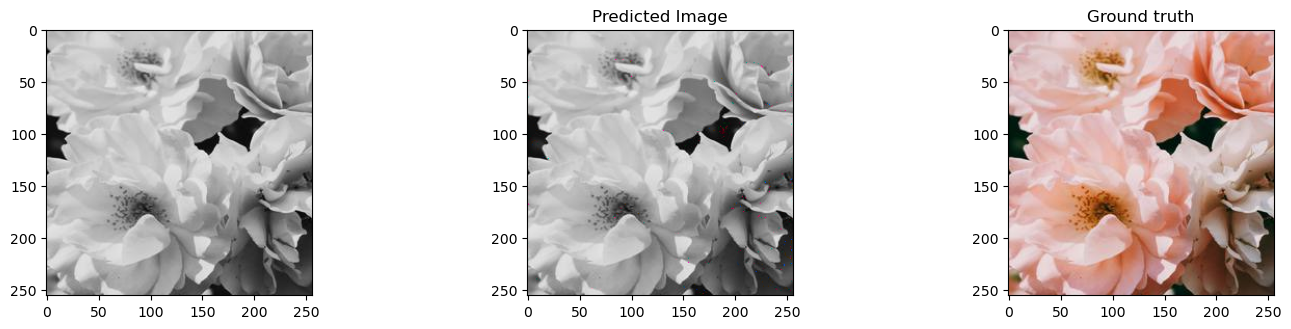

In [127]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)